# Hysteresis simulation

Following the protocol of Schwarz and coworkers (Schwarz et al., 1998), we mimic cycles of induced hypocalcemia followed by a brief return to normocalcemia and a second hypocalcemic episode. Experimentally, this sequence produced a strong first PTH peak (reflecting rapid release from stored hormone), but no second transient peak, as the short recovery at normal calcium was insufficient to replenish storage. Our simulation reproduces this hysteresis effect: an initial sharp rise of PTH during the first calcium drop, followed by the absence of a second transient peak upon re-exposure to hypocalcemia.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

from ptg_model.parameters import SteadyState
from ptg_model.model import deriv
from ptg_model.utils import smooth_pw


In [2]:
# --- Define base healthy steady state ---
unit_Ca = "mg/dL"
Copt = 5.0       # healthy midpoint of Ca
Popt = 3.6       # normal phosphate (mg/dL)
Dopt = 40        # normal calcitriol (ng/L)

# start from steady state
y0 = SteadyState(Copt, Copt, Dopt)
PTHopt = y0[3] / 3 * 9.434
S0 = y0[0] + y0[1]

In [3]:
from ptg_model.utils import smooth_pw, smooth_pw_matrix

def exp_drop(t, C_high, C_low, tau=10/60):
    A = (C_high - C_low) / (1 - np.exp(-0.5 / tau))
    return C_high - A * (1 - np.exp(-t / tau))

def exp_rise(t, C_start, C_high, tau=3/60):
    return C_start + (C_high - C_start) * (np.exp(t / tau) - 1) / (np.exp((1/6) / tau) - 1)

def make_calcium_endpoints(Copt=5.0, cycles=2):
    C_high = Copt
    C_low = 0.85 * Copt
    x_points = []
    y_points = []
    time = [30/60, 70/60, 10/60]  
    for k in range(cycles):
        base = k * np.sum(time)  

        C_at_0p5 = exp_drop(1, C_high, C_low)

        C_at_2 = exp_rise(1/6, C_at_0p5, C_high)

        if k == 0:
            x_points += [base + 0.0, base + time[0], base + np.sum(time[0:2]), base + np.sum(time)]
            y_points += [C_high, C_at_0p5, C_at_0p5, C_at_2]
        else:
            x_points += [base + time[0], base + np.sum(time[0:2]), base + np.sum(time)]
            y_points += [C_at_0p5, C_at_0p5, C_at_2]

    return np.array([x_points, y_points])


In [4]:
def deriv_with_hysteresis(
    t,
    y,
    endpoints_P,
    endpoints_D,
    Copt,
    Dopt,
    Popt,
    C_pat,
    P_pat,
    D_pat,
    S0,
    tf,
    GFR_in,
    y_pat,
    endpoints,
    alpha
):
    C_dynamic = smooth_pw(t, endpoints,alpha)

    return deriv(
        t,
        y,
        endpoints_P,
        endpoints_D,
        Copt,
        Dopt,
        Popt,
        C_dynamic,  
        P_pat,
        D_pat,
        S0,
        tf,
        GFR_in,
        y_pat
    )


In [5]:
tf = 150/60 # simulate 150 min

endpoints_P = np.array([[0, 1], [1, 1]])  # phosphate constant
endpoints_D = np.array([[0, 1], [1, 1]])  # vitamin D constant

C_pat = Copt
P_pat = Popt
D_pat = Dopt


endpoints = make_calcium_endpoints(Copt=Copt, cycles=3)
y_pat = np.array(y0 + [0, 0])  
GFR_in = 1
alpha = 60
args = (endpoints_P, endpoints_D, Copt, Dopt, Popt,
        C_pat, P_pat, D_pat, S0, tf, GFR_in, y_pat, endpoints,alpha)



In [6]:
t_span = (0, tf)
sn = solve_ivp(deriv_with_hysteresis, t_span, y_pat,
               args=args, method="BDF", dense_output=True)

print("Simulation finished:", sn.success)


Simulation finished: True


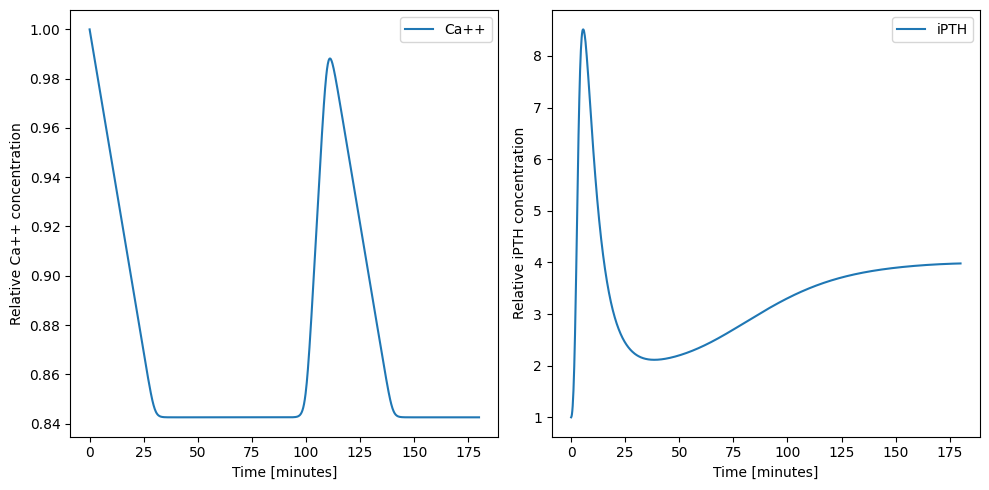

In [7]:
# --- Plot results ---
# Calcium and iPTH over time
# Plot relative to baseline
t_eval = np.linspace(0, 3, 1000)  # 6 hours
Ca_values = smooth_pw_matrix(t_eval, endpoints,alpha)

Ca_percent = Ca_values / Copt
iPTH_percent =  (sn.sol(t_eval)[3,:] / 3 * 9.434) / PTHopt

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(t_eval*60, Ca_percent, label="Ca++")
plt.xlabel("Time [minutes]")
plt.ylabel("Relative Ca++ concentration")
plt.legend()

plt.subplot(1,2,2)
plt.plot(t_eval*60, iPTH_percent, label="iPTH")
plt.xlabel("Time [minutes]")
plt.ylabel("Relative iPTH concentration")
plt.legend()
plt.tight_layout()
plt.show()
